In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import seaborn as sns
%matplotlib inline

In [3]:
def mta_data_to_df(weeks_of_data):
    
    to_concat = []
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    
    for week in weeks_of_data:
        file = url.format(week)
        df = pd.read_csv(file, parse_dates=[['DATE','TIME']], keep_date_col=True)
        to_concat.append(df)

    return pd.concat(to_concat)

In [5]:
mta = mta_data_to_df([200905, 200912, 200919])
mta.rename(columns={"EXITS                                                               ": "EXITS"}, inplace=True)

In [28]:
totals = mta.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['ENTRIES'].min().reset_index()
totals[['PREV_DATE', 'PREV_ENTRIES']] = (totals.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE', 'ENTRIES'].apply(lambda x: x.shift(1)))
totals.dropna(subset=['PREV_DATE'], axis=0, inplace=True)
totals['DAILY ENTRIES'] = totals['ENTRIES']-totals['PREV_ENTRIES']
totals.loc[(totals['DAILY ENTRIES'] > 10000)  |(totals['DAILY ENTRIES'] < 0)] = np.nan
totals = totals.groupby("STATION")["DAILY ENTRIES"].sum()
totals.sort_values(ascending=False, inplace=True)
totals = totals.reset_index()

exits_by_date = mta.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'])['EXITS'].min().reset_index()
exits_by_date[['PREV_DATE', 'PREV_EXITS']] = (exits_by_date.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE', 'EXITS'].apply(lambda x: x.shift(1)))
exits_by_date.dropna(subset=['PREV_DATE'], axis=0, inplace=True)
exits_by_date['DAILY EXITS'] = exits_by_date['EXITS']-exits_by_date['PREV_EXITS']
exits_by_date.loc[(exits_by_date['DAILY EXITS'] > 10000) | (exits_by_date['DAILY EXITS'] < 0)] = np.nan
exits_by_date = exits_by_date.groupby("STATION")["DAILY EXITS"].sum()
exits_by_date.sort_values(ascending=False, inplace=True)
exits_by_date = exits_by_date.reset_index()


<ipython-input-28-c23bdb526879>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  totals[['PREV_DATE', 'PREV_ENTRIES']] = (totals.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE', 'ENTRIES'].apply(lambda x: x.shift(1)))
<ipython-input-28-c23bdb526879>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  exits_by_date[['PREV_DATE', 'PREV_EXITS']] = (exits_by_date.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DATE', 'EXITS'].apply(lambda x: x.shift(1)))


In [39]:
totals['DAILY EXITS'] = exits_by_date['DAILY EXITS']
totals["TOTAL TRAFFIC"] = totals["DAILY ENTRIES"] + totals["DAILY EXITS"]

In [40]:
all_station_traffic = totals.sort_values(by="TOTAL TRAFFIC", ascending=False)
all_station_entries = totals.sort_values(by="DAILY ENTRIES", ascending=False)
all_station_exits = totals.sort_values(by="DAILY EXITS", ascending=False)

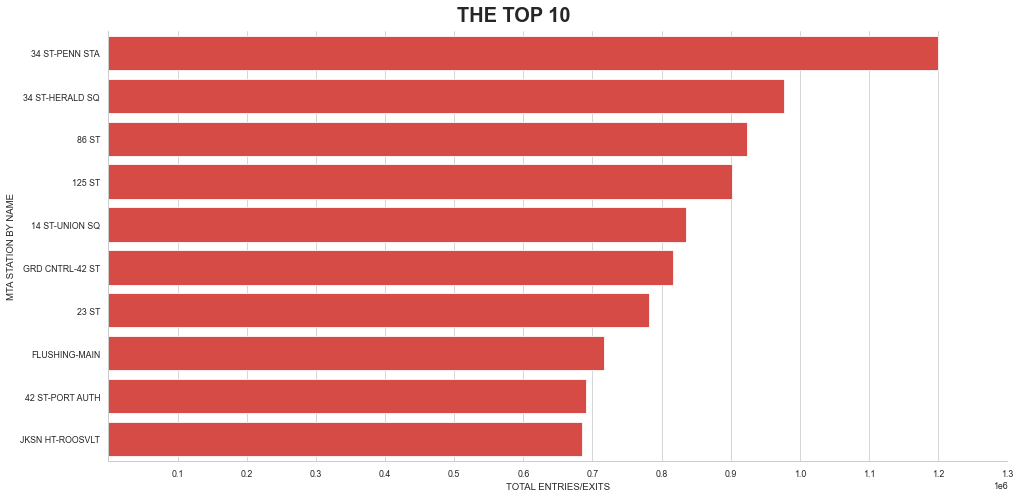

In [41]:
# Plotting the top 10 stations in terms of daily traffic
# Choice of #EE352E came from: http://web.mta.info/developers/resources/line_colors.htm
sns.set_context("paper")
sns.set_style('whitegrid')
enmax_palette = ["#EE352E", "#EE352E", "#EE352E", "#EE352E", "#EE352E", "#EE352E", \
                 "#EE352E", "#EE352E", "#EE352E", "#EE352E"]
top_10 = sns.catplot(x="TOTAL TRAFFIC", y="STATION", data=all_station_traffic.head(10), \
            palette=enmax_palette, height=7, aspect=2, kind="bar")
top_10.set(xticks=[100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, \
                   1000000, 1100000, 1200000, 1300000])
top_10.set_axis_labels("TOTAL ENTRIES/EXITS", "MTA STATION BY NAME")
top_10.fig.subplots_adjust(top=0.93)
top_10.fig.suptitle("THE TOP 10", size=20, fontweight="bold");
top_10.fig.subplots_adjust(wspace=.05, hspace=.05)
top_10.savefig('Top 10.png')